# Tracking speed - Benchmarks 2

In this experiment, we extend the results of the Benchmarks notebook by assessing the performance to track 1D `NumPy` arrays.
we evaluate the tracking performance of:

* MLflow - https://mlflow.org/
* FastTrackML - https://github.com/G-Research/fasttrackml
* WandB - https://wandb.ai/
* Neptune - https://neptune.ai/
* Aim - https://aimstack.io/
* Comet - https://www.comet.com/
* MLtraq - https://mltraq.com/

Varying:

* Number of arrays
* Size of arrays

Configuration:
* Tracking `Numpy` arrays as values, disabling everything else such as git, code, environment and system stats
* Experiments running/tracking offline, logging disabled, storage on local filesystem
* Every experiment starts with an empty directory for storage
* Results averaged on `10` runs


## Imports and utility functions

In [1]:
%load_ext pyinstrument

In [2]:
import logging
import shutil
import threading
import uuid
from contextlib import contextmanager, redirect_stderr, redirect_stdout
from os import devnull, environ, makedirs, remove

import aim
import comet_ml
import fasttrackml
import matplotlib.pyplot as plt
import mlflow
import mltraq
import neptune
import numpy as np
import pandas as pd
import wandb
from mltraq.utils.plot import bar_plot

In [3]:
# Versions

print("mlflow", mlflow.__version__)
print("neptune", neptune.__version__)
print("wandb", wandb.__version__)
print("aim", aim.__version__.__version__)
print("comet", comet_ml.__version__)
print("mltraq", mltraq.__version__)
print("fasttrackml", "0.5.0b2")

mlflow 2.11.0
neptune 1.9.1
wandb 0.16.3
aim 3.18.1
comet 3.38.1
mltraq 0.0.121
fasttrackml 0.5.0b2


In [4]:
# Utility functions


@contextmanager
def suppress_stdout_stderr():
    """
    A context manager that redirects stdout and stderr to devnull.
    """
    with open(devnull, "w") as fnull:
        with redirect_stderr(fnull) as err, redirect_stdout(fnull) as out:
            yield (err, out)


def remove_file(pathname):
    """
    Remove file `pathname` if existing.
    """
    try:
        remove(pathname)
    except OSError:
        pass


def create_dir(pathdir):
    """
    Create `pathdir` recursively. If it already exists, do nothing.
    """
    makedirs(pathdir, exist_ok=True)

## Test procedure for WandB

In [5]:
def test_wandb(n_values=1, size=1):
    """
    Test Weights & Biases tracking with a specified number of arrays.
    """

    # Required to silence Python output and disable sentry tracking.
    # This must be inside the test function to propagate to child processes.
    environ["WANDB_SILENT"] = "true"
    environ["WANDB_ERROR_REPORTING"] = "false"
    environ["WANDB_DISABLE_GIT"] = "true"
    environ["DISABLE_CODE"] = "true"

    tmp_dir = f"tmp/{uuid.uuid4()}"
    create_dir(f"{tmp_dir}/wandb")
    wandb.init(
        project=str(uuid.uuid4()),
        group=str(uuid.uuid4()),
        dir=tmp_dir,
        mode="offline",
    )
    for _ in range(n_values):
        table = wandb.Table(columns=["values"])
        table.add_data(np.zeros(size))
        wandb.log({"table": table})
        # Data is stored as JSON in files named table_something.table.json
    wandb.finish()

In [6]:
%%pyinstrument
test_wandb()


_     ._   __/__   _ _  _  _ _/_   Recorded: 22:05:15  Samples:  200
 /_//_/// /_\ / //_// / //_'/ //     Duration: 2.208     CPU time: 0.232
/   _/                      v4.6.2

Program: /Users/michele/dev/mltraq/.venv/lib/python3.11/site-packages/ipykernel_launcher.py -f /Users/michele/Library/Jupyter/runtime/kernel-4628e86f-4f45-480c-a136-a710608a175c.json

2.207 <module>  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_62231/1666376201.py:1
`- 2.207 test_wandb  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_62231/725407112.py:1
   |- 1.543 finish  wandb/sdk/wandb_run.py:4108
   |     [28 frames hidden]  wandb, threading, <built-in>, sentry_sdk
   |        1.002 lock.acquire  <built-in>
   |- 0.618 init  wandb/sdk/wandb_init.py:940
   |     [34 frames hidden]  wandb, <built-in>, jupyter_server, re
   `- 0.045 Run.wrapper  wandb/sdk/wandb_run.py:389
         [16 frames hidden]  wandb, subprocess

## Test procedure for MLflow

In [7]:
def test_mlflow(n_values=1, size=1):
    """
    Test MLflow tracking with a specified number of arrays.
    """

    create_dir("tmp")
    db_fname = f"tmp/{uuid.uuid4()}.db"
    mlflow.set_tracking_uri(f"sqlite:///{db_fname}")
    experiment_id = mlflow.create_experiment(str(uuid.uuid4()))
    with mlflow.start_run(experiment_id=experiment_id):
        for value_id in range(0, n_values):
            # Datasets don't seem to work, this doesn't result in any tracked data:
            # dataset = mlflow.data.from_numpy(np.zeros(size), source="test") # noqa
            # mlflow.log_input(dataset, context="training")# noqa

            # .log_param has a size limit of 6K
            # .log_metric works only with floats
            # .log_text writes to a file in dir ./mlruns

            # Not optimal, but there doesn't seem to be a better way without first
            # writing it to disk before creating one more copy.
            # large blobs are tacked on the filesystem as artifacts.
            # E.g., ".../artifacts/value_0".

            mlflow.log_text(str(np.zeros(size).tobytes()), f"value_{value_id}")

    mlflow.end_run()
    remove_file(db_fname)

In [8]:
%%pyinstrument
test_mlflow()


2024/03/04 22:05:17 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2024/03/04 22:05:17 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

_     ._   __/__   _ _  _  _ _/_   Recorded: 22:05:17  Samples:  367
 /_//_/// /_\ / //_// / //_'/ //     Duration: 1.767     CPU time: 0.628
/   _/                      v4.6.2

Program: /Users/michele/dev/mltraq/.venv/lib/python3.11/site-packages/ipykernel_launcher.py -f /Users/michele/Library/Jupyter/runtime/kernel-4628e86f-4f45-480c-a136-a710608a175c.json

1.767 <module>  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_62231/2371405818.py:1
`- 1.767 test_mlflow  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_62231/469692556.py:1
   |- 1.322 ActiveRun.__exit__  mlflow/tracking/fluent.py:195
   |     [13 frames hidden]  mlflow, comet_ml, threading, <built-in>
   |        1.096 lock.acquire  <built-in>
   |- 0.378 create_experiment  mlflow/tracking/fluent.py:1601
   |     [55 frames hidden]  mlflow, alembic, sqlalchemy, <string>
   `- 0.054 wrapper  comet_ml/monkey_patching.py:261
         [12 frames hidden]  comet_ml, mlflow

## Test procedure for FastTrackML

In [9]:
# Requires `fml server --log-level error`
# Data store in the "./artifacts" directory.


def test_fasttrackml(n_values=1, size=1):
    """
    Test FastTrackML tracking with a specified number of arrays.
    """

    fasttrackml.set_tracking_uri("http://localhost:5000")
    client = fasttrackml.FasttrackmlClient()
    experiment_id = "0"
    run = client.create_run(experiment_id)
    run_id = run.info.run_id
    for value_id in range(0, n_values):
        client.log_text(run_id, str(np.zeros(size).tobytes()), f"value_{value_id}")
    client.set_terminated(run_id)

In [10]:
%%pyinstrument
test_fasttrackml()


_     ._   __/__   _ _  _  _ _/_   Recorded: 22:05:19  Samples:  28
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.030     CPU time: 0.027
/   _/                      v4.6.2

Program: /Users/michele/dev/mltraq/.venv/lib/python3.11/site-packages/ipykernel_launcher.py -f /Users/michele/Library/Jupyter/runtime/kernel-4628e86f-4f45-480c-a136-a710608a175c.json

0.030 <module>  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_62231/2744998001.py:1
`- 0.030 test_fasttrackml  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_62231/1085605332.py:3
   |- 0.022 FasttrackmlClient.create_run  mlflow/tracking/client.py:299
   |     [66 frames hidden]  mlflow, entrypoints, configparser, <b...
   |- 0.005 FasttrackmlClient.log_text  mlflow/tracking/client.py:1261
   |     [37 frames hidden]  mlflow, contextlib, requests, urllib,...
   `- 0.003 FasttrackmlClient.set_terminated  mlflow/tracking/client.py:1938
         [23 frames hidden]  mlflow, requests, urllib, <built-in>,...

## Test procedure for Neptune

In [59]:
def test_neptune(n_values=1, size=1):
    """
    Test Neptune tracking with a specified number of arrays.
    """

    run = neptune.init_run(
        project=f"workspace/{str(uuid.uuid4())}",
        mode="offline",
        git_ref=False,
    )
    for _ in range(0, n_values):
        # https://docs.neptune.ai/logging/arrays_and_tensors/#logging-numpy-arrays
        run["totrack"].append(neptune.types.File.as_image(np.zeros((size, 1))))
        # File encoded in string format, example:
        # ./data-1.log:{"obj": {"type": "LogImages", "path": ["valuetotrack"],
        #               "values": [{"value": {"data": "iVBORw0KGgo ...
    run.wait()
    run.stop()

In [61]:
%%pyinstrument
test_neptune()

_     ._   __/__   _ _  _  _ _/_   Recorded: 22:55:14  Samples:  10
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.011     CPU time: 0.013
/   _/                      v4.6.2

Program: /Users/michele/dev/mltraq/.venv/lib/python3.11/site-packages/ipykernel_launcher.py -f /Users/michele/Library/Jupyter/runtime/kernel-4628e86f-4f45-480c-a136-a710608a175c.json

0.010 <module>  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_62231/3214493869.py:1
`- 0.010 test_neptune  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_62231/469202094.py:1
   |- 0.008 Run.__init__  neptune/metadata_containers/run.py:307
   |     [27 frames hidden]  neptune, pathlib, <frozen posixpath>,...
   |- 0.001 Run.stop  neptune/metadata_containers/metadata_container.py:410
   |     [6 frames hidden]  neptune, json
   `- 0.001 Handler.inner_fun  neptune/handler.py:85
         [12 frames hidden]  neptune, json

## Test procedure for Aim

In [13]:
def test_aim(n_values=1, size=1):
    """
    Test Aim tracking with a specified number of arrays.
    """

    create_dir("tmp/aim/")
    repo = f"tmp/aim/{uuid.uuid4()}"
    # Doc: https://aimstack.readthedocs.io/en/latest/refs/sdk.html#aim.sdk.run.Run
    # Experiments in Aim match to what we call runs in this notebook.
    run = aim.Run(
        repo=repo,
        experiment=str(uuid.uuid4()),
        system_tracking_interval=None,
        capture_terminal_logs=False,
    )
    for _ in range(0, n_values):
        # With:
        #    run.track({"value": [np.zeros(size)]}) # noqa
        # Error:
        #    TypeError: Unhandled non-native value `[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]`
        #    of type `<class 'numpy.ndarray'>`.
        run.track({"value": [np.zeros(size).tobytes()]})

In [14]:
%%pyinstrument
test_aim()

_     ._   __/__   _ _  _  _ _/_   Recorded: 22:05:19  Samples:  37
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.937     CPU time: 0.058
/   _/                      v4.6.2

Program: /Users/michele/dev/mltraq/.venv/lib/python3.11/site-packages/ipykernel_launcher.py -f /Users/michele/Library/Jupyter/runtime/kernel-4628e86f-4f45-480c-a136-a710608a175c.json

0.936 <module>  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_62231/3340399674.py:1
|- 0.857 test_aim  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_62231/3590247435.py:1
|  `- 0.857 wrapper  aim/ext/exception_resistant.py:65
|        [32 frames hidden]  aim, subprocess, <built-in>, sqlalche...
|           0.438 waitpid  <built-in>
|           0.209 Repo._get_container  aim/sdk/repo.py:268
|           `- 0.208 [self]  aim/sdk/repo.py
`- 0.079 finalize.__call__  weakref.py:585
      [2 frames hidden]  weakref

## Test procedure for Comet

In [39]:
def test_comet(n_values=1, size=1):
    """
    Test Comet tracking with a specified number of arrays.
    """

    tmp_dir = f"tmp/comet/{uuid.uuid4()}"
    create_dir(tmp_dir)
    run = comet_ml.OfflineExperiment(
        project_name=str(uuid.uuid4()),
        log_code=False,
        log_graph=False,
        log_env_gpu=False,
        log_env_cpu=False,
        log_env_network=False,
        log_env_disk=False,
        log_env_host=False,
        log_git_metadata=False,
        offline_directory=tmp_dir,
        experiment_key=str(uuid.uuid4().hex),
        display_summary_level=0,
    )
    for _ in range(0, n_values):
        # .log_other, .log_metrics don't really track
        # the value, it converts the object to a
        # short string eg. "[0, 0, ...., 0, 0]".
        run.log_text(str(np.zeros(size).tolist()))

    run.end()

In [40]:
%%pyinstrument
test_comet()

_     ._   __/__   _ _  _  _ _/_   Recorded: 22:36:51  Samples:  18
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.075     CPU time: 0.023
/   _/                      v4.6.2

Program: /Users/michele/dev/mltraq/.venv/lib/python3.11/site-packages/ipykernel_launcher.py -f /Users/michele/Library/Jupyter/runtime/kernel-4628e86f-4f45-480c-a136-a710608a175c.json

0.075 <module>  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_62231/3382937944.py:1
`- 0.075 test_comet  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_62231/664877131.py:1
   |- 0.063 OfflineExperiment.end  comet_ml/experiment.py:687
   |     [20 frames hidden]  comet_ml, <built-in>, threading, zipf...
   |        0.055 sleep  <built-in>
   |- 0.010 OfflineExperiment.__init__  comet_ml/offline.py:231
   |     [29 frames hidden]  comet_ml, threading, <built-in>, copy...
   `- 0.001 create_dir  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_62231/1120774479.py:24
      `- 0.001 makedirs  <frozen os>:200
            [3 frames hidden]  <frozen os>, <built-in>

## Test procedure for MLtraq

In [17]:
def test_mltraq(n_values=1, size=1):
    """
    Test MLtraq tracking with a specified number of arrays.
    """

    create_dir("tmp")
    db_fname = f"tmp/{uuid.uuid4()}.db"
    session = mltraq.create_session(f"sqlite:///{db_fname}")
    with mltraq.options().ctx({"tqdm.disable": True}):
        experiment = session.create_experiment()
        with experiment.run() as run:
            run.fields.ds = mltraq.DataStore()
            run.fields.ds.value = []
            for _ in range(0, n_values):
                run.fields.ds.value.append(np.zeros(size))
        experiment.persist()
    experiment.delete()
    remove_file(db_fname)

In [18]:
%%pyinstrument
test_mltraq()

_     ._   __/__   _ _  _  _ _/_   Recorded: 22:05:21  Samples:  41
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.060     CPU time: 0.047
/   _/                      v4.6.2

Program: /Users/michele/dev/mltraq/.venv/lib/python3.11/site-packages/ipykernel_launcher.py -f /Users/michele/Library/Jupyter/runtime/kernel-4628e86f-4f45-480c-a136-a710608a175c.json

0.059 <module>  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_62231/2389778167.py:1
`- 0.059 test_mltraq  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_62231/303676234.py:1
   |- 0.042 Experiment.persist  mltraq/experiment.py:364
   |  |- 0.020 Database.pandas_to_sql  mltraq/storage/database.py:128
   |  |  `- 0.020 wrapper  pandas/util/_decorators.py:325
   |  |        [44 frames hidden]  pandas, sqlalchemy, <built-in>, <stri...
   |  |           0.016 Cursor.execute  <built-in>
   |  |- 0.012 Experiment.delete  mltraq/experiment.py:397
   |  |  |- 0.008 Query.count  sqlalchemy/orm/query.py:3053
   |  |  |     [82 frames hidden]  sqlalchemy, <string>, <frozen abc>, <...
   |  |  |- 0.003 Database.drop_table  mltraq/storage/database.py:170
   |  |  |  `- 0.003 MetaData.reflect  sqlalchemy/sql/schema.py:5619
   |  |  |        [36 frames hidden]  sqlalchemy, <string>
   |  |  `- 0.001 Session.query  sqlalchemy/orm/session.py:2876
   |  |        [8 frames hidden]  sqlalchemy
   |  |- 0.007 runs_to_sql  mltraq/storage/serialization.py:111
   |  |  |- 0.005 Runs.df  mltraq/runs.py:66
   |  |  |  |- 0.003 reorder_columns  mltraq/utils/frames.py:6
   |  |  |  |  `- 0.003 DataFrame.__getitem__  pandas/core/frame.py:4050
   |  |  |  |        [15 frames hidden]  pandas
   |  |  |  `- 0.002 json_normalize  pandas/io/json/_normalize.py:245
   |  |  |        [10 frames hidden]  pandas
   |  |  |- 0.001 Series.map  pandas/core/series.py:4611
   |  |  |     [3 frames hidden]  pandas
   |  |  |        0.001 map_array  pandas/core/algorithms.py:1667
   |  |  |        `- 0.001 <lambda>  mltraq/storage/serialization.py:129
   |  |  |           `- 0.001 serialize  mltraq/storage/serialization.py:40
   |  |  |              `- 0.001 DataPakSerializer.serialize  mltraq/storage/serializers/datapak.py:95
   |  |  |                 `- 0.001 DataPakSerializer.encode  mltraq/storage/serializers/datapak.py:116
   |  |  |                    `- 0.001 DataPakSerializer.encode_magic_key  mltraq/storage/serializers/datapak.py:152
   |  |  |                       `- 0.001 DataStore.to_url  mltraq/storage/datastore.py:19
   |  |  |                          `- 0.001 DataStoreIO.serialize_write  mltraq/storage/datastore.py:73
   |  |  |                             `- 0.001 DataStoreIO.write  mltraq/storage/datastore.py:81
   |  |  |                                `- 0.001 BufferedWriter.__exit__  <built-in>
   |  |  `- 0.001 reorder_columns  mltraq/utils/frames.py:6
   |  |     `- 0.001 DataFrame.__getitem__  pandas/core/frame.py:4050
   |  |           [7 frames hidden]  pandas
   |  |- 0.002 Session.commit  sqlalchemy/orm/session.py:1936
   |  |     [29 frames hidden]  sqlalchemy, <string>
   |  `- 0.001 Experiment.record  mltraq/experiment.py:333
   |     `- 0.001 serialize  mltraq/storage/serialization.py:40
   |        `- 0.001 DataPakSerializer.serialize  mltraq/storage/serializers/datapak.py:95
   |           `- 0.001 PickleSerializer.serialize  mltraq/storage/serializers/pickle.py:42
   |- 0.009 Session.__init__  mltraq/session.py:22
   |  `- 0.009 Database.__init__  mltraq/storage/database.py:44
   |     |- 0.007 MetaData.create_all  sqlalchemy/sql/schema.py:5801
   |     |     [55 frames hidden]  sqlalchemy, <built-in>, <string>, con...
   |     `- 0.002 create_engine  <string>:1
   |           [10 frames hidden]  <string>, sqlalchemy, threading
   |- 0.006 Experiment.delete  mltraq/experiment.py:397
   |  |- 0.004 Database.drop_table  mltraq/storage/database.py:170
   |  |  |- 0.003 MetaData.reflect  sqlalchemy/sql/schema.py:5619
   |  |  |     [3

## Defining the experiment

In [19]:
def eval_time(run: mltraq.Run):
    """
    Measure the time required to track a set of experiments.
    """

    # Disable logging
    logging.disable()

    with suppress_stdout_stderr():
        log = mltraq.Sequence()

        # Start tracking time.
        log.append(tag="begin")
        if run.params.method == "MLflow":
            test_mlflow(n_values=run.params.n_values, size=run.params.size)
        elif run.params.method == "MLtraq":
            test_mltraq(n_values=run.params.n_values, size=run.params.size)
        elif run.params.method == "Neptune":
            test_neptune(n_values=run.params.n_values, size=run.params.size)
        elif run.params.method == "WandB":
            test_wandb(n_values=run.params.n_values, size=run.params.size)
        elif run.params.method == "Aim":
            test_aim(n_values=run.params.n_values, size=run.params.size)
        elif run.params.method == "Comet":
            test_comet(n_values=run.params.n_values, size=run.params.size)
        elif run.params.method == "FastTrackML":
            test_fasttrackml(n_values=run.params.n_values, size=run.params.size)
        else:
            raise Exception("unknown method")

        log.append(tag="end")
        durations = log.df().pivot_table(index="tag", values="timestamp")["timestamp"]
        run.fields.duration = (durations.end - durations.begin).total_seconds()
        run.fields.n_threads = threading.active_count()
        run.fields |= run.params


def cleanup(run: mltraq.Run):
    # Remove temporary files
    shutil.rmtree(".neptune", ignore_errors=True)
    shutil.rmtree(".cometml-runs", ignore_errors=True)
    shutil.rmtree("mlruns", ignore_errors=True)
    shutil.rmtree("tmp", ignore_errors=True)
    shutil.rmtree("artifacts", ignore_errors=True)

## Defining the plots

In [20]:
def report_results(experiment: mltraq.Experiment, save_svg_to=None):
    """
    Given an executed experiment, report the results with a plot and a table.
    """

    fig, (ax1, ax2, ax3) = plt.subplots(figsize=[10, 2], nrows=1, ncols=3)
    fig.tight_layout()
    plt.subplots_adjust(hspace=0.4)

    with mltraq.options().ctx(
        {
            "matplotlib.rc": {"hatch.color": "white"},
            "matplotlib.style": "tableau-colorblind10",
        }
    ):

        bar_plot(
            experiment.runs.df(),
            x="n_values",
            x_label="Number of arrays",
            y="duration",
            group="method",
            yerr=True,
            ax=ax1,
            y_label="Duration (s)",
            y_lim={"bottom": 0},
            y_grid=False,
            legend={
                "loc": "lower center",
                "bbox_to_anchor": (0.5, -1.1),
                "fancybox": True,
                "shadow": False,
                "ncol": 2,
            },
        )

        bar_plot(
            experiment.runs.df(),
            x="size",
            x_label="Size of arrays",
            y="duration",
            yerr=True,
            y_label="Duration (s)",
            group="method",
            ax=ax2,
            y_lim={"bottom": 0},
            legend={
                "loc": "lower center",
                "bbox_to_anchor": (0.5, -1.1),
                "fancybox": True,
                "shadow": False,
                "ncol": 2,
            },
        )
        ax2.yaxis.label.set_visible(False)

        bar_plot(
            experiment.runs.df(),
            x="method",
            x_label="Method",
            y="duration",
            yerr=True,
            ax=ax3,
            y_lim={"bottom": 0},
            legend={
                "loc": "lower center",
                "bbox_to_anchor": (0.5, -1.1),
                "fancybox": True,
                "shadow": False,
                "ncol": 2,
            },
        )
        ax3.yaxis.label.set_visible(False)
        ax3.tick_params(axis="x", labelrotation=45)

    if save_svg_to:
        plt.savefig(save_svg_to, bbox_inches="tight", pad_inches=0.1)

    plt.show()

    # Display aggregated results table (duration and multiplier to the best-performing method)
    print("\nAveraged results by method\n")
    df = experiment.runs.df().groupby("method")["duration"].mean().sort_values().to_frame()
    df["ratio_to_best"] = df["duration"] / df["duration"].iloc[0]
    display(df)
    print("\n")

## Experiments

* In the rest of the notebook, we experiment varying number of experiments, runs and values.
* With some differences, all methods capture these parameters.


In [22]:
# Create an MLtraq session to track the benchmarks
session = mltraq.create_session("sqlite:///local/benchmarks2.db")

### Experiment 1: How long does tracking a 1D NumPy array of length 1M take?

In this experiment, we evaluate the time required to start a new experiment and track a single array of length 1M (default dtype is `numpy.float64`), which is 8M bytes if written to disk.

Most methods do NOT support serialization of NumPy arrays, and our test procedures take care of doing it.

In [32]:
len(np.zeros(10**6).tobytes())

8000000

In [46]:
e = session.create_experiment("exp-1", if_exists="replace")
e.add_runs(
    method=[
        "Aim",
        "Comet",
        "WandB",
        "Neptune",
        "MLtraq",
        "MLflow",
        "FastTrackML",
    ],
    i=range(10),
    n_values=[1],
    size=[int(10**6)],
)

# Parallelization is disabled as it might affect results.
e.execute([cleanup, eval_time, cleanup], n_jobs=1).persist(if_exists="replace")

  1%|1         | 1/70 [00:01<01:12,  1.05s/it]

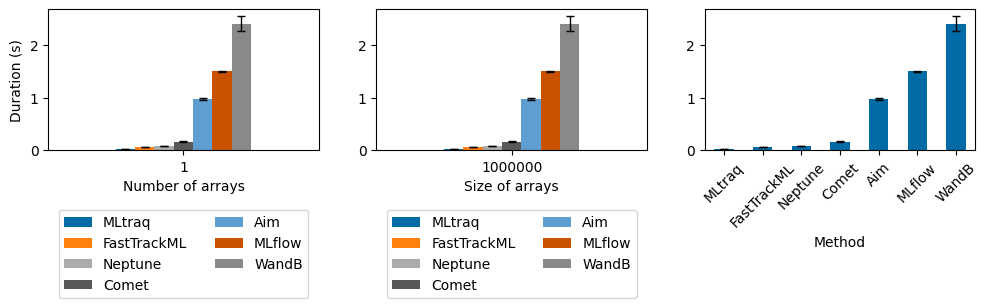


Averaged results by method



,duration,ratio_to_best
method,,
MLtraq,0.021222,1.000000
FastTrackML,0.057818,2.724473
Neptune,0.075345,3.550323
Comet,0.158975,7.491096
Aim,0.970749,45.742775
MLflow,1.495465,70.468002
WandB,2.406217,113.383660


In [47]:
# Report results
report_results(session.load("exp-1"))

* Results are very similar to experiment 1 in the Benchmarks notebook. The time cost is dominated by start up (database/filesystem, threads).
* MLtraq is faster than Neptune due to the inefficient serialization strategy of Neptune, that relies on a string format to encode the contents of the array.

### Experiment 2: How much time to track 1, 5, 10 arrays of size 10K, 100K and 1M?

In [23]:
e = session.create_experiment("exp-2", if_exists="replace")
e.add_runs(
    method=[
        "Aim",
        "Comet",
        "Neptune",
        "MLtraq",
        "MLflow",
        "FastTrackML",
        "WandB",
    ],
    i=range(10),
    n_values=[1, 5, 10],
    size=[int(10**4), int(10**5), int(10**6)],
)

# WandB often fails with errors "ValueError: I/O operation on closed file.",
# and "BrokenPipeError: [Errno 32] Broken pipe".

# Parallelization is disabled as it might affect results.
e.execute([cleanup, eval_time, cleanup], n_jobs=1).persist(if_exists="replace")

  0%|          | 1/630 [00:00<01:11,  8.83it/s]

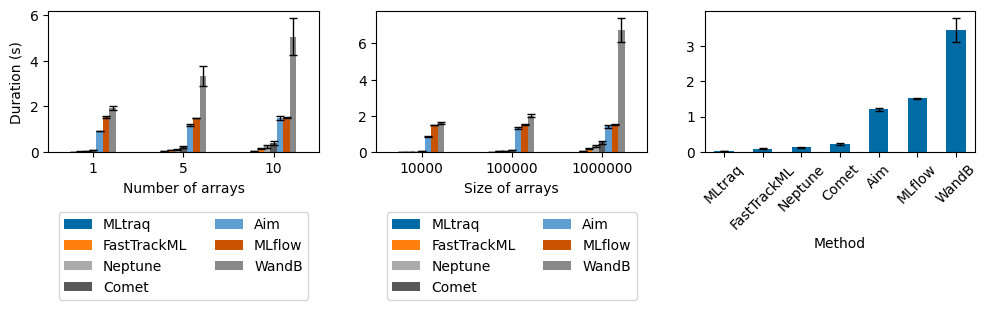


Averaged results by method



,duration,ratio_to_best
method,,
MLtraq,0.032019,1.000000
FastTrackML,0.094793,2.960512
Neptune,0.133985,4.184508
Comet,0.239411,7.477100
Aim,1.201265,37.516955
MLflow,1.518831,47.434924
WandB,3.444595,107.578853


In [24]:
# Report results
report_results(session.load("exp-2"))

Trends remain similar to Experiment 1, except WandB whose time explodes.

### Experiment 3: How much time to track 1, 10, 100, 1K and 10K arrays of size 1K?

In [32]:
e = session.create_experiment("exp-3", if_exists="replace")
e.add_runs(
    method=["Neptune", "MLtraq", "Comet", "FastTrackML"],
    i=range(10),
    n_values=[1, int(10**1), int(10**2), int(10**3), int(10**4)],
    size=[1, int(10**2), int(10**3)],
)

# Parallelization is disabled as it might affect results.
e.execute([cleanup, eval_time, cleanup], n_jobs=1).persist(if_exists="replace")

  0%|          | 1/600 [00:00<01:42,  5.86it/s]

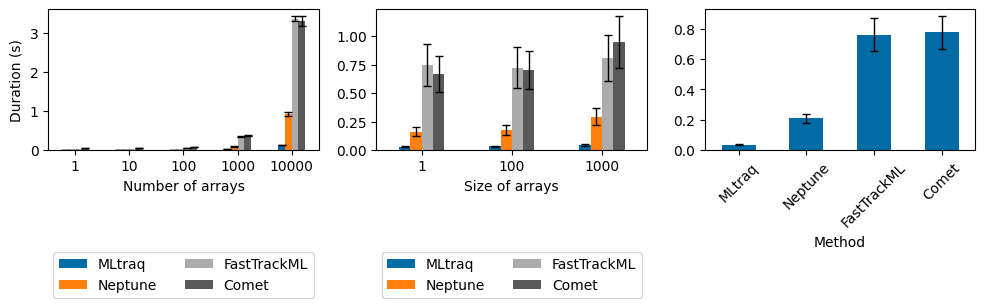


Averaged results by method



,duration,ratio_to_best
method,,
MLtraq,0.036131,1.000000
Neptune,0.208983,5.784029
FastTrackML,0.759888,21.031474
Comet,0.775569,21.465460


In [38]:
# Report results
report_results(session.load("exp-3"))

* Comet and FastTrackML are the worst performing, with time dominated by creating the many files.
* MLtraq is 5x faster than Neptune and 20x faster than the others. Its strategy to create a bag of objects that are stored together is much more efficient than storing each object independently, especially if the number of objects is high.

### Aggregates

In [41]:
dfs = [session.load(f"exp-{idx}").runs.df() for idx in [1, 2, 3]]
df = pd.concat(dfs).groupby("method").duration.mean().sort_values().to_frame()
df["ratio_to_best"] = df["duration"] / df["duration"].iloc[0]
df

,duration,ratio_to_best
method,,
MLtraq,0.034054,1.000000
Neptune,0.176638,5.186935
FastTrackML,0.492371,14.458373
Comet,0.557888,16.382261
Aim,1.178213,34.597961
MLflow,1.516494,44.531504
WandB,3.340757,98.100551


### Save plots to SVG files

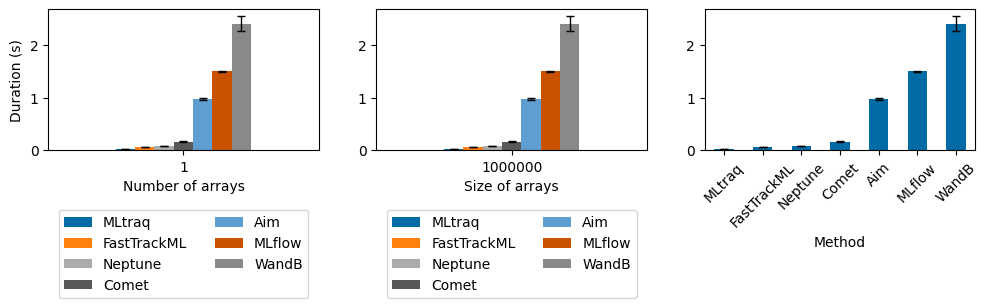


Averaged results by method



,duration,ratio_to_best
method,,
MLtraq,0.021222,1.000000
FastTrackML,0.057818,2.724473
Neptune,0.075345,3.550323
Comet,0.158975,7.491096
Aim,0.970749,45.742775
MLflow,1.495465,70.468002
WandB,2.406217,113.383660


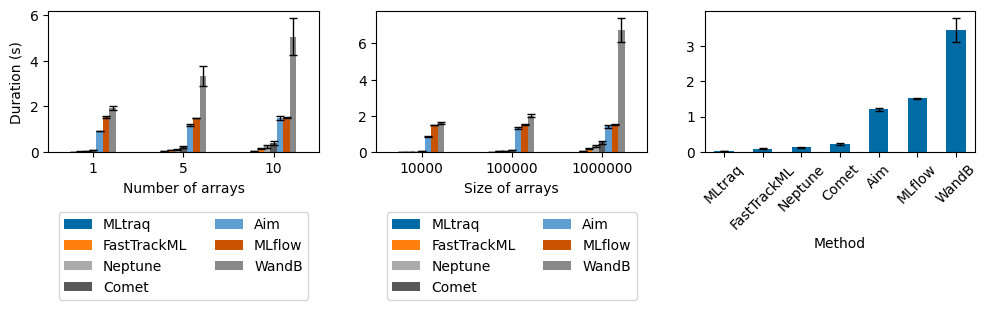


Averaged results by method



,duration,ratio_to_best
method,,
MLtraq,0.032019,1.000000
FastTrackML,0.094793,2.960512
Neptune,0.133985,4.184508
Comet,0.239411,7.477100
Aim,1.201265,37.516955
MLflow,1.518831,47.434924
WandB,3.444595,107.578853


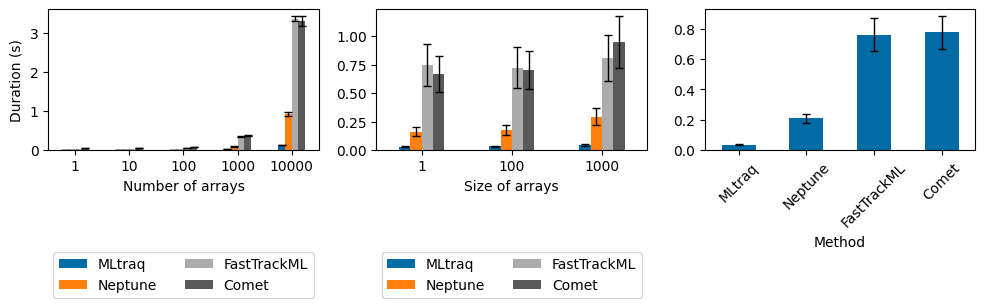


Averaged results by method



,duration,ratio_to_best
method,,
MLtraq,0.036131,1.000000
Neptune,0.208983,5.784029
FastTrackML,0.759888,21.031474
Comet,0.775569,21.465460


In [42]:
# Create an MLtraq session to reload the benchmarks
session = mltraq.create_session("sqlite:///local/benchmarks2.db")

# Save plots to SVG files
report_results(
    session.load("exp-1"),
    save_svg_to="../mkdocs/assets/img/benchmarks2/exp-1.svg",
)
report_results(
    session.load("exp-2"),
    save_svg_to="../mkdocs/assets/img/benchmarks2/exp-2.svg",
)
report_results(
    session.load("exp-3"),
    save_svg_to="../mkdocs/assets/img/benchmarks2/exp-3.svg",
)

## Conclusion

In the experiments, MLtraq is, on average, 4-100x faster than the other methods. As the number and size of the tracked arrays increases, MLtraq stands out even more, being 20x faster than others. MLtraq has been designed to have a robust and complete serialization/storage mechanism for complex Python objects. If tracking a wide range of objects and speed are your priorities, you should consider MLtraq to run your experiments.